In [3]:
import bigbadbrain as bbb
import os
import numpy as np
import nibabel as nib
import psutil
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import time
import psutil

In [4]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_21/func_0'

# Load data

In [5]:
savefile = os.path.join(directory, 'cs230', 'raw_reshape.nii.npy')
X = np.load(savefile)

KeyboardInterrupt: 

In [5]:
X.shape

(535936, 4370)

In [1]:
X.nbytes

NameError: name 'X' is not defined

In [6]:
save_file = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(save_file)
print(brain.shape)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 6.79 ms
(128, 79, 53, 4370)


In [10]:
brain.dtype

dtype('float32')

In [9]:
brain = brain.astype('float32')

In [12]:
np.savez(os.path.join(directory, 'cs230', 'raw_brain.npz'), brain)

# Reshape

In [4]:
t0 = time.time()
X = brain.reshape(-1,4370)
print(time.time()-t0)

71.41660737991333


In [10]:
os.mkdir(os.path.join(directory, 'cs230'))

In [12]:
savefile = os.path.join(directory, 'cs230', 'raw_reshape.nii')
np.save(savefile, X)

TypeError: _save_dispatcher() got an unexpected keyword argument 'dtype'

In [9]:
X.shape

(535936, 4370)

In [10]:
X2 = X[:1000,:100]

In [11]:
X2.shape

(1000, 100)

# Interp

In [14]:
brain_x_original.shape

(4370,)

In [15]:
t0=time.time()
brain_x_original = timestamps[:,25]
expt_len = 1000*30*60 #in ms
new_rate = 100 # in ms
brain_x_new = np.arange(0,expt_len,new_rate)

brain_interp_temp = interp1d(brain_x_original, X, kind='cubic', fill_value="extrapolate", axis=-1)
brain_interp = brain_interp_temp(brain_x_new)
print(time.time()-t0)

264.0548825263977


In [33]:
savefile = os.path.join(directory, 'cs230', 'raw_upsampled_float32.npy')
np.save(savefile, brain_interp)

In [27]:
brain_interp.shape

(128, 79, 53, 18000)

In [24]:
brain_interp = brain_interp.reshape(128, 79, 53, 18000)

In [30]:
brain_interp = brain_interp.astype('float32')

In [32]:
brain_interp.nbytes

38587392000

In [29]:
brain_interp.nbytes

77174784000

In [ ]:
t0 = time.time()
brain.shape = (-1,4370)
print(time.time()-t0)

In [4]:
brain.shape

(128, 79, 53, 4370)

In [20]:
X.nbytes

9368161280

In [10]:
brain += 1

In [22]:
memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
print('Current memory usage: {:.2f}GB'.format(memory_usage))

Current memory usage: 115.26GB


# Load timestamps

In [8]:
timestamps = bbb.load_timestamps(os.path.join(directory,'imaging'))
print(timestamps.shape)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 46.39 ms
(4370, 53)


# Load fictrac

In [15]:
fictrac = bbb.load_fictrac(os.path.join(directory,'fictrac'))


~~ load_fictrac ~~
load_fictrac done. Duration: 3.12 sec


# Interpolate (upsample)

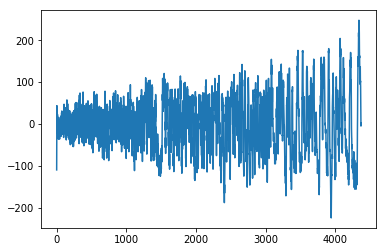

In [24]:
plt.plot(pca_loadings[:,0])
plt.show()

In [41]:
brain_x_original = timestamps[:,25]
expt_len = 1000*30*60 #in ms
new_rate = 100 # in ms
brain_x_new = np.arange(0,expt_len,new_rate)

brain_interp_temp = interp1d(brain_x_original, pca_loadings, kind='cubic', bounds_error = False, axis=0)
brain_interp = brain_interp_temp(brain_x_new)

In [45]:
#for interpolating behavior to neural data
def interp_fictrac(fictrac, behavior, fps, expt_len, new_rate):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)    
    fictrac_interp = fictrac_interp_temp(new_rate)

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [49]:
expt_len = 1000*30*60 #in ms
fps = 50 #of fictrac camera

fictracs = {}
for behavior in ['Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, expt_len, brain_x_new)

In [51]:
fictracs['Y'].shape

(18000,)

In [52]:
labels = np.vstack((fictracs['Y'], fictracs['Z'])).T
labels = labels/np.std(labels, axis=0)

In [53]:
labels.shape

(18000, 2)

In [55]:
save_file = os.path.join(directory, 'pca', 'upsampled_temporal')
np.save(save_file, brain_interp)

In [56]:
save_file = os.path.join(directory, 'pca', 'upsampled_behavior')
np.save(save_file, labels)